In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.8 MB/s eta 0:00:00


In [2]:
from catboost import CatBoostClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('drive/MyDrive/VK/VK_without_columns_with_bday_fixed')

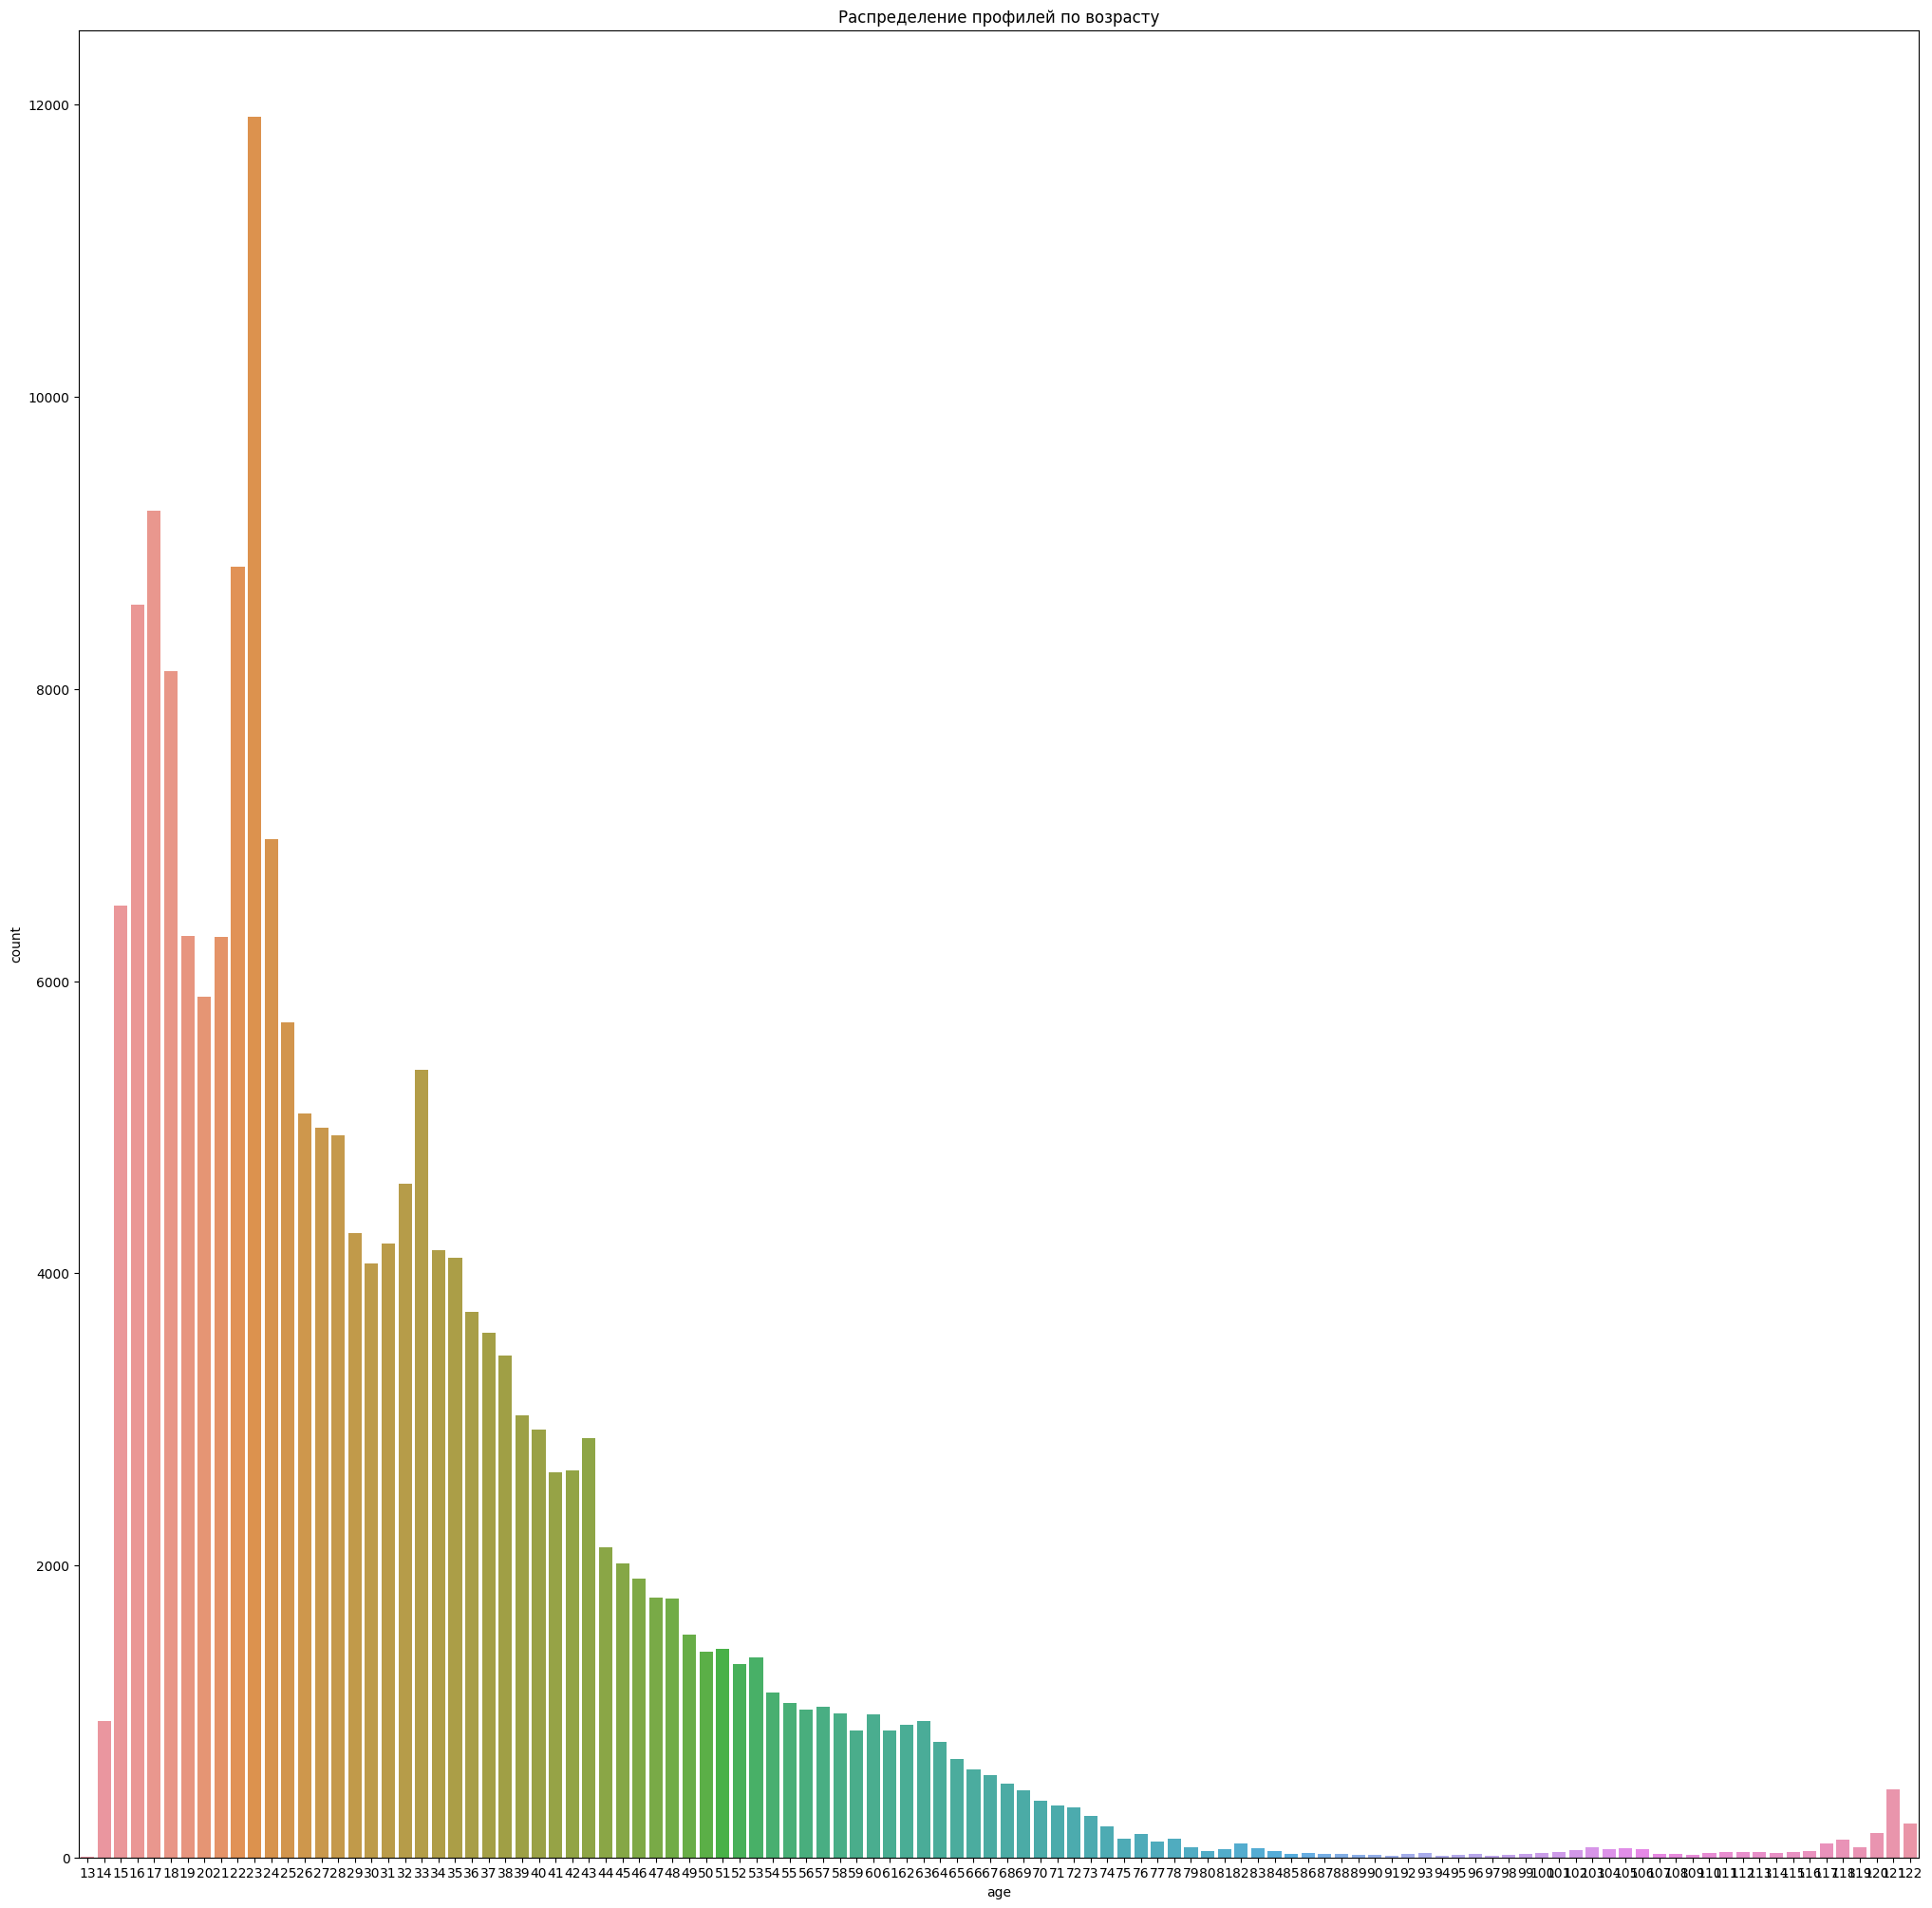

In [5]:
plt.figure(figsize=(25, 25))
plt.title('Распределение профилей по возрасту')
sns.countplot(data = df, x ='age')
plt.show()

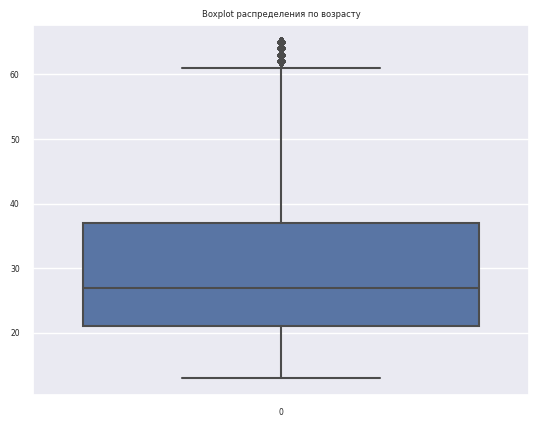

In [19]:
plt.title('Boxplot распределения по возрасту')
sns.boxplot(df['age'])
plt.show()

In [9]:
def get_num_people_by_age_category(df):
    df["age_group"] = pd.cut(x=df['age'], bins=[0,19,25,35,65], labels=[1,2,3,4])
    return df

In [10]:
df = get_num_people_by_age_category(df)

In [11]:
df = df[df.age_group.isna() == False]

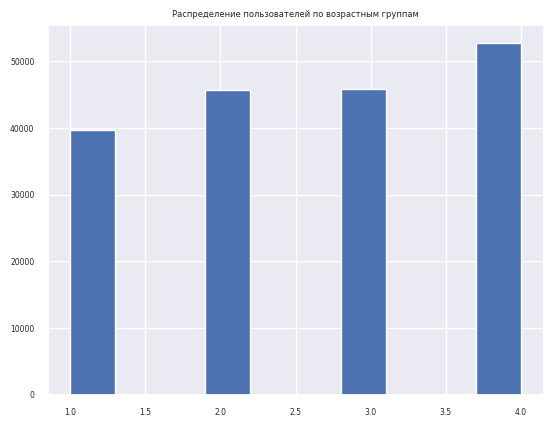

In [18]:
plt.title('Распределение пользователей по возрастным группам')
df.age_group.hist()
plt.show()

In [13]:
df.age_group = df.age_group.astype(int)

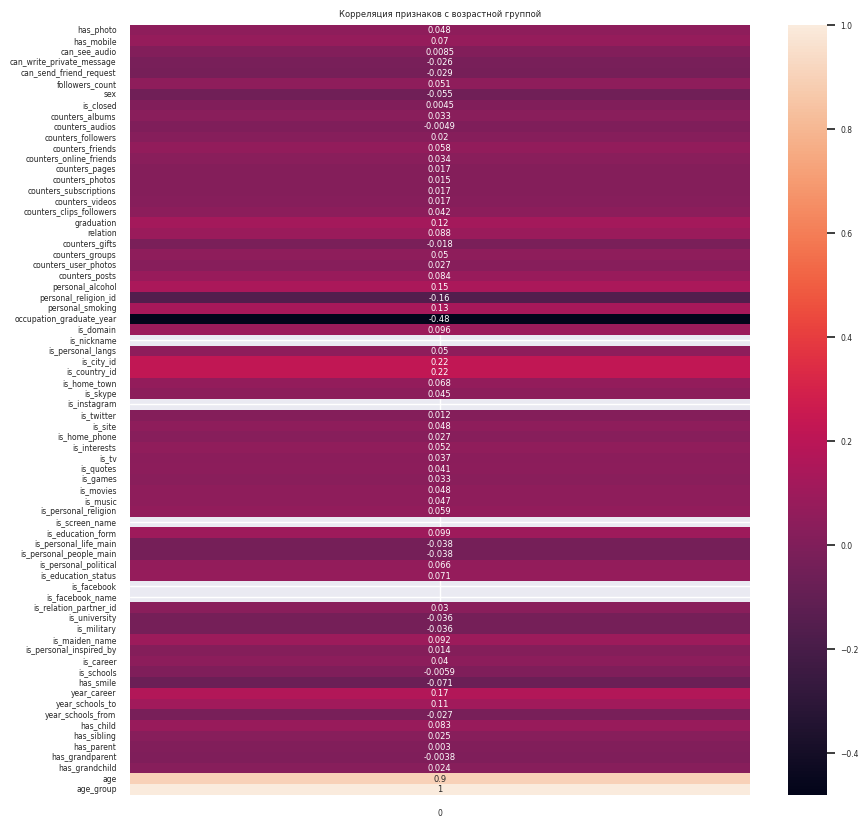

In [25]:
matplotlib.rcParams['savefig.dpi'] = 1000
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Корреляция признаков с возрастной группой')
sns.set(font_scale=0.5)
sns.heatmap(df.corr(numeric_only = True)['age_group'].to_numpy().reshape((-1, 1)), yticklabels=df.corr(numeric_only = True)['age_group'].index, ax=ax, annot=True)
plt.show()

In [12]:
cat_cols = ['has_photo', 'has_mobile', 'can_see_audio', 'wall_default',
       'can_write_private_message', 'can_send_friend_request',
       'sex', 'is_closed',
       'relation', 'occupation_type',
       'personal_alcohol', 'personal_religion_id', 'personal_smoking',
        'is_domain', 'is_nickname',
       'is_personal_langs', 'is_city_id', 'is_country_id', 'is_home_town',
       'is_skype', 'is_instagram', 'is_twitter', 'is_site', 'is_home_phone',
       'is_interests', 'is_tv', 'is_quotes', 'is_games', 'is_movies',
       'is_music', 'is_personal_religion', 'is_screen_name',
       'is_education_form', 'is_personal_life_main', 'is_personal_people_main',
       'is_personal_political', 'is_education_status', 'is_facebook',
       'is_facebook_name', 'is_relation_partner_id', 'is_university',
       'is_military', 'is_maiden_name', 'is_personal_inspired_by', 'is_career',
       'is_schools']


In [13]:
for i in cat_cols:
  df[i].fillna(-1, inplace = True)

In [14]:
for i in ['has_photo', 'has_mobile', 'can_see_audio', 'can_write_private_message', 'can_send_friend_request', 'relation', 'personal_alcohol', 'personal_religion_id', 'personal_smoking']:
  df[i] = df[i].astype(int)

In [15]:
X = df.drop(columns = ['bdate', 'age', 'age_group'])
y = df.age_group

# CatBoost

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 21)

In [17]:
sc = StandardScaler()

X_train[[x for x in X_train.columns.tolist() if x not in cat_cols]] = sc.fit_transform(X_train[[x for x in X_train.columns.tolist() if x not in cat_cols]])
X_test[[x for x in X_test.columns.tolist() if x not in cat_cols]] = sc.transform(X_test[[x for x in X_test.columns.tolist() if x not in cat_cols]])

In [18]:
cbm = CatBoostClassifier(cat_features=cat_cols, task_type="GPU", devices='0:1')

In [19]:
cbm.fit(X_train, y_train, verbose=True)

Learning rate set to 0.177332
0:	learn: 1.3487776	total: 19.2ms	remaining: 19.2s
1:	learn: 1.3247620	total: 37.7ms	remaining: 18.8s
2:	learn: 1.3072368	total: 65ms	remaining: 21.6s
3:	learn: 1.2933743	total: 83.1ms	remaining: 20.7s
4:	learn: 1.2827024	total: 100ms	remaining: 19.9s
5:	learn: 1.2741366	total: 118ms	remaining: 19.6s
6:	learn: 1.2667486	total: 135ms	remaining: 19.1s
7:	learn: 1.2601015	total: 151ms	remaining: 18.8s
8:	learn: 1.2542761	total: 169ms	remaining: 18.6s
9:	learn: 1.2503041	total: 186ms	remaining: 18.4s
10:	learn: 1.2454599	total: 202ms	remaining: 18.2s
11:	learn: 1.2414905	total: 223ms	remaining: 18.4s
12:	learn: 1.2365581	total: 250ms	remaining: 18.9s
13:	learn: 1.2326826	total: 265ms	remaining: 18.7s
14:	learn: 1.2292945	total: 280ms	remaining: 18.4s
15:	learn: 1.2254014	total: 296ms	remaining: 18.2s
16:	learn: 1.2228862	total: 308ms	remaining: 17.8s
17:	learn: 1.2203179	total: 321ms	remaining: 17.5s
18:	learn: 1.2176860	total: 333ms	remaining: 17.2s
19:	learn

In [20]:
y_pred = cbm.predict(X_test)

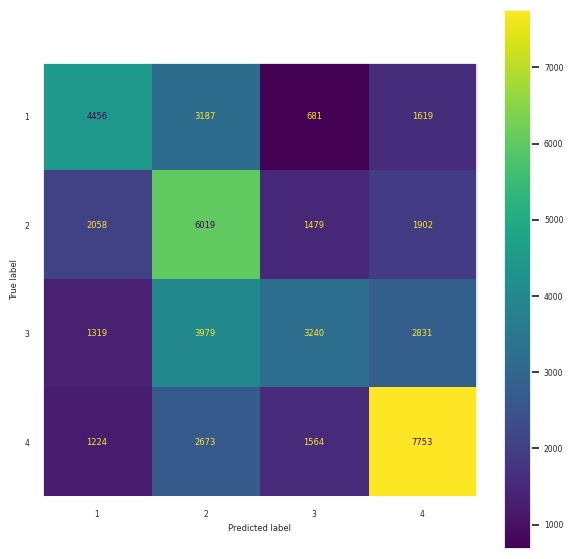

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=cbm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=cbm.classes_)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(ax = ax)
plt.grid(False)
plt.show()

In [22]:
from sklearn import metrics

In [23]:
print(metrics.precision_score(y_test, y_pred, average = 'macro'))
print(metrics.recall_score(y_test, y_pred, average = 'macro'))

0.47161607457554655
0.46129399851741165


In [24]:
print(metrics.precision_score(y_test, y_pred, average = 'macro'))
print(metrics.recall_score(y_test, y_pred, average = 'macro'))

0.47161607457554655
0.46129399851741165


In [25]:
print(metrics.precision_score(y_test, y_pred, average = 'weighted'))
print(metrics.recall_score(y_test, y_pred, average = 'weighted'))

0.47393738479024367
0.4668580375782881


In [ ]:
# model = CatBoostClassifier(cat_features=cat_cols, task_type="GPU", devices='0:1')

# grid = {'depth':[3,1,2,6,4,5,7,8,9,10],
#           'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3],
#           'l2_leaf_reg':[3,1,5,10,100],
#           'border_count':[32,5,10,20,50,100,200],}

# grid_search_result = model.randomized_search(grid,
#                                        n_iter=100,
#                                        X=X_train,
#                                        y=y_train,
#                                        plot=True)

In [ ]:
grid_search_result['params']

{'border_count': 100, 'depth': 6, 'l2_leaf_reg': 10, 'learning_rate': 0.2}

In [26]:
cbm = CatBoostClassifier(cat_features=cat_cols, border_count=100, depth=6, l2_leaf_reg=10, learning_rate=0.2, task_type="GPU", devices='0:1')

In [27]:
cbm.fit(X_train, y_train, verbose=True)

0:	learn: 1.3456868	total: 85.4ms	remaining: 1m 25s
1:	learn: 1.3204253	total: 173ms	remaining: 1m 26s
2:	learn: 1.3018345	total: 254ms	remaining: 1m 24s
3:	learn: 1.2891062	total: 338ms	remaining: 1m 24s
4:	learn: 1.2783316	total: 418ms	remaining: 1m 23s
5:	learn: 1.2702936	total: 497ms	remaining: 1m 22s
6:	learn: 1.2625782	total: 577ms	remaining: 1m 21s
7:	learn: 1.2558599	total: 654ms	remaining: 1m 21s
8:	learn: 1.2500831	total: 733ms	remaining: 1m 20s
9:	learn: 1.2450276	total: 819ms	remaining: 1m 21s
10:	learn: 1.2401074	total: 893ms	remaining: 1m 20s
11:	learn: 1.2356947	total: 971ms	remaining: 1m 19s
12:	learn: 1.2316636	total: 1.04s	remaining: 1m 18s
13:	learn: 1.2283724	total: 1.12s	remaining: 1m 18s
14:	learn: 1.2239833	total: 1.2s	remaining: 1m 18s
15:	learn: 1.2212226	total: 1.28s	remaining: 1m 18s
16:	learn: 1.2184158	total: 1.36s	remaining: 1m 18s
17:	learn: 1.2160854	total: 1.44s	remaining: 1m 18s
18:	learn: 1.2138681	total: 1.53s	remaining: 1m 19s
19:	learn: 1.2113137	t

In [28]:
y_pred = cbm.predict(X_test)

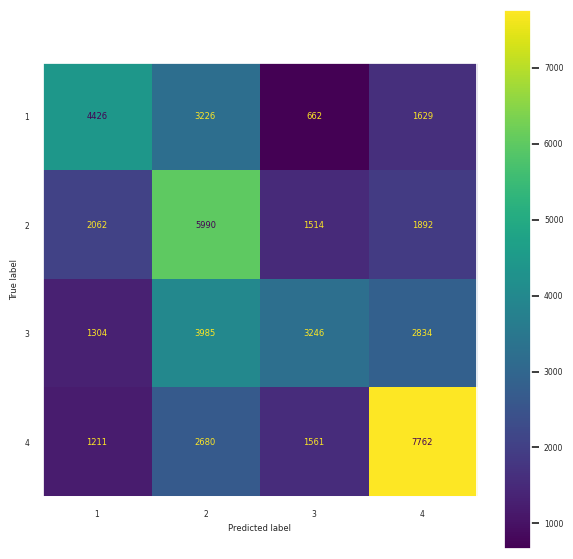

In [29]:
cm = confusion_matrix(y_test, y_pred, labels=cbm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=cbm.classes_)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(ax = ax)
plt.grid(False)
plt.show()

In [30]:
print(metrics.precision_score(y_test, y_pred, average = 'macro'))
print(metrics.recall_score(y_test, y_pred, average = 'macro'))

0.4708677273595894
0.4602091650076092


In [31]:
print(metrics.precision_score(y_test, y_pred, average = 'macro'))
print(metrics.recall_score(y_test, y_pred, average = 'macro'))

0.4708677273595894
0.4602091650076092


In [32]:
print(metrics.precision_score(y_test, y_pred, average = 'weighted'))
print(metrics.recall_score(y_test, y_pred, average = 'weighted'))

0.47321136164403177
0.4659011830201809


# Random Forest

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 21)

In [34]:
from sklearn.preprocessing import StandardScaler

In [35]:
sc = StandardScaler()

X_train[[x for x in X_train.columns.tolist() if x not in cat_cols]] = sc.fit_transform(X_train[[x for x in X_train.columns.tolist() if x not in cat_cols]])
X_test[[x for x in X_test.columns.tolist() if x not in cat_cols]] = sc.transform(X_test[[x for x in X_test.columns.tolist() if x not in cat_cols]])

In [36]:
X_train.fillna(-1, inplace = True)

In [38]:
bool_columns = df.select_dtypes(include=['bool']).columns

In [39]:
X_train['wall_default'] = X_train['wall_default'].map({'all': 0 ,'owner' : 1, -1: -1})
X_train['occupation_type'] = X_train['occupation_type'].map({'school': 0 ,'university' : 1, 'work' : 2, -1 : -1})
X_train[bool_columns] = X_train[bool_columns].astype(int)

In [40]:
X_test.fillna(-1, inplace = True)
X_test['wall_default'] = X_test['wall_default'].map({'all': 0 ,'owner' : 1, -1: -1})
X_test['occupation_type'] = X_test['occupation_type'].map({'school': 0 ,'university' : 1, 'work' : 2, -1:-1})
X_test[bool_columns] = X_test[bool_columns].astype(int)
X_test.fillna(-1, inplace = True)

In [42]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [43]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [4, 6, 8, 10, 20, 30, 40]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [44]:
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [4, 6, 8, 10, 20, 30, 40, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [45]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 25, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=25,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [4, 6, 8, 10, 20, 30, 40,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [46]:
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': True}

In [47]:
rf_random.best_estimator_

RandomForestClassifier(max_depth=20, max_features='auto', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=2000)

In [48]:
y_pred = rf_random.best_estimator_.predict(X_test)

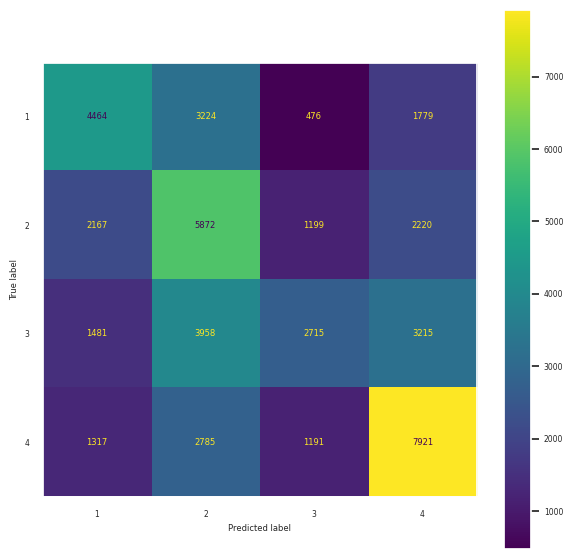

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # вынести импорты в начало
cm = confusion_matrix(y_test, y_pred, labels=rf_random.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_random.best_estimator_.classes_)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(ax = ax)
plt.grid(False)
plt.show()

In [50]:
from sklearn import metrics

In [51]:
print(metrics.precision_score(y_test, y_pred, average = 'macro'))
print(metrics.recall_score(y_test, y_pred, average = 'macro'))

0.4634979795376385
0.4499216751498139


In [52]:
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': True}

In [53]:
rf = RandomForestClassifier()

In [54]:
rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)

In [55]:
print(metrics.precision_score(y_test, y_rf, average = 'macro'))
print(metrics.recall_score(y_test, y_rf, average = 'macro'))

0.4401045484255186
0.4334838507611602
